In [1]:
import numpy as np
import pandas as pd
import scipy as sp

# from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from fermat import Fermat
from sklearn.datasets import load_iris, load_digits, make_moons


### Comparación de del humilde `PicoKDE` con implementaciones de referencia

In [2]:
mvn = sp.stats.multivariate_normal


class PicoKDE:
    """un estimador de densidad multivariada por núcleos austero."""

    def __init__(self, bandwidth=1):
        self.bandwidth = bandwidth

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        return self

    def density(self, X, log=True):
        densities = np.array(
            [mvn(Xi, self.bandwidth**2 * np.eye(self.dim_)).pdf(X) for Xi in self.X_]
        ).mean(axis=0)

        return np.log(densities) if log else densities


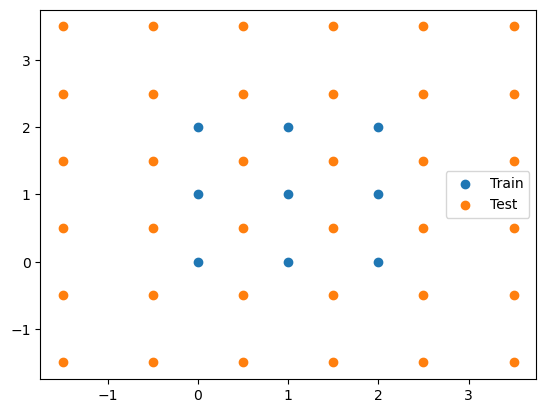

In [3]:
# Write a function `square_mesh` that returns a meshgrid of `dim` dimensions, with each dimension ranging from `a` to `b` with `step` increments
from itertools import product


def lattice(a, b, step=1, dim=2, array=True):
    side = np.arange(a, b, step)
    gen = product(*[side] * dim)
    return np.array([*gen]) if array else gen


a, b, step = 0, 3, 1
bw = 0.5
margin = step / 2 + 2 * bw
results = []
X_train = lattice(a, b, step, dim=2)
X_test = lattice(a - margin, b + margin, step, dim=2)


plt.scatter(X_train[:, 0], X_train[:, 1], label="Train")
plt.scatter(X_test[:, 0], X_test[:, 1], label="Test")
plt.legend()
plt.show()


In [4]:
pico_kde = PicoKDE(bandwidth=bw).fit(X_train)
pico_kde.density(X_test)

array([-11.64813647,  -7.63031591,  -6.94620855,  -6.94620855,
        -7.63031591, -11.64813647,  -7.63031591,  -3.61249536,
        -2.928388  ,  -2.928388  ,  -3.61249536,  -7.63031591,
        -6.94620855,  -2.928388  ,  -2.24428064,  -2.24428064,
        -2.928388  ,  -6.94620855,  -6.94620855,  -2.928388  ,
        -2.24428064,  -2.24428064,  -2.928388  ,  -6.94620855,
        -7.63031591,  -3.61249536,  -2.928388  ,  -2.928388  ,
        -3.61249536,  -7.63031591, -11.64813647,  -7.63031591,
        -6.94620855,  -6.94620855,  -7.63031591, -11.64813647])

In [5]:
from sklearn.neighbors import KernelDensity

scikit_kde = KernelDensity(bandwidth=bw).fit(X_train)
scikit_kde.score(X_test)


-210.05894957916462

In [6]:
def _score(self, X):
    return np.sum(self.density(X))


PicoKDE.score = _score


In [7]:
assert pico_kde.density(X_test).sum() == pico_kde.score(X_test)
pico_kde.score(X_test)


-210.05894957916462

In [8]:
%%timeit
KernelDensity(bandwidth=bw).fit(X_train).score_samples(X_test)

206 µs ± 5.28 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Square lattice

In [9]:
# Import the necessary methods to train a multivariete kernel density estimator using `statsmodels`, `scikit-learn` and `scipy`
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from scipy.stats import gaussian_kde

KDEMultivariate.predict = lambda self, X: np.log(self.pdf(X))
KernelDensity.predict = KernelDensity.score_samples
gaussian_kde.predict = lambda self, X: self.logpdf(X.T)
PicoKDE.predict = PicoKDE.density

a, b, step = 0, 1, 0.12
bw = 0.16
margin = step / 2 + 4 * bw
results = []
for dim in range(1, 4):
    X_train = lattice(a, b, step, dim)
    X_test = lattice(a - margin, b + margin, step, dim)
    print(dim, X_train.shape, X_test.shape, X_test[0])
    estimators = {
        "statsmodels": KDEMultivariate(data=X_train, var_type="c" * dim, bw=[bw] * dim),
        "scikit": KernelDensity(bandwidth=bw).fit(X_train),
        "scipy": gaussian_kde(X_train.T, bw_method=bw),
        "pico": PicoKDE(bandwidth=bw).fit(X_train),
    }
    log_dens = {k: est.predict(X_test).round(3) for k, est in estimators.items()}
    results.extend(
        {
            "dim": dim,
            "method": name,
            "p": sum(np.exp(logd) * (step**dim)),
            "logd": logd,
        }
        for name, logd in log_dens.items()
    )


1 (9, 1) (20, 1) [-0.7]
2 (81, 2) (400, 2) [-0.7 -0.7]
3 (729, 3) (8000, 3) [-0.7 -0.7 -0.7]


In [10]:
df = pd.DataFrame(results)


In [11]:
df[df.dim == 1]


,dim,method,p,logd
0,1,statsmodels,0.99998,"[-10.825, -7.804, -5.329, -3.387, -1.956, -0.9..."
1,1,scikit,0.99998,"[-10.825, -7.804, -5.329, -3.387, -1.956, -0.9..."
2,1,scipy,1.02223,"[-88.785, -61.007, -38.438, -21.076, -8.924, -..."
3,1,pico,0.99998,"[-10.825, -7.804, -5.329, -3.387, -1.956, -0.9..."


In [12]:
df

,dim,method,p,logd
0,1,statsmodels,0.999980,"[-10.825, -7.804, -5.329, -3.387, -1.956, -0.9..."
1,1,scikit,0.999980,"[-10.825, -7.804, -5.329, -3.387, -1.956, -0.9..."
2,1,scipy,1.022230,"[-88.785, -61.007, -38.438, -21.076, -8.924, -..."
3,1,pico,0.999980,"[-10.825, -7.804, -5.329, -3.387, -1.956, -0.9..."
4,2,statsmodels,0.999999,"[-21.651, -18.629, -16.154, -14.212, -12.781, ..."
5,2,scikit,0.999999,"[-21.651, -18.629, -16.154, -14.212, -12.781, ..."
6,2,scipy,1.067156,"[-197.156, -166.292, -141.215, -121.925, -108...."
7,2,pico,0.999999,"[-21.651, -18.629, -16.154, -14.212, -12.781, ..."
8,3,statsmodels,0.999990,"[-32.476, -29.455, -26.979, -25.038, -23.607, ..."
9,3,scikit,0.999990,"[-32.476, -29.455, -26.979, -25.038, -23.607, ..."


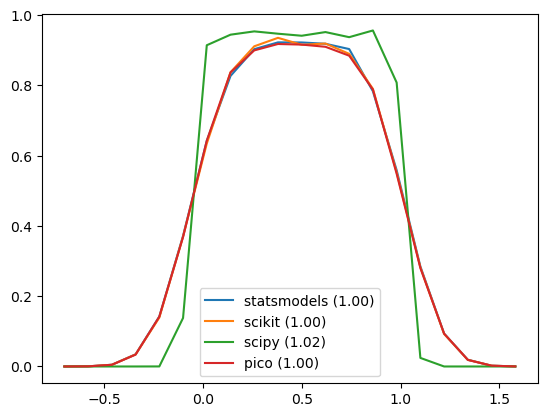

In [13]:
segment = lattice(a - margin, b + margin, step, dim=1).flatten()
noise = mvn(mean=np.ones_like(segment), cov=(0.025 / 3) ** 2 * np.eye(len(segment)))
noise.rvs()

for idx, row in df[df.dim == 1].iterrows():
    plt.plot(
        segment, np.exp(row.logd) * noise.rvs(), label=f"{row.method} ({row.p:.2f})"
    )
plt.legend()
plt.show()


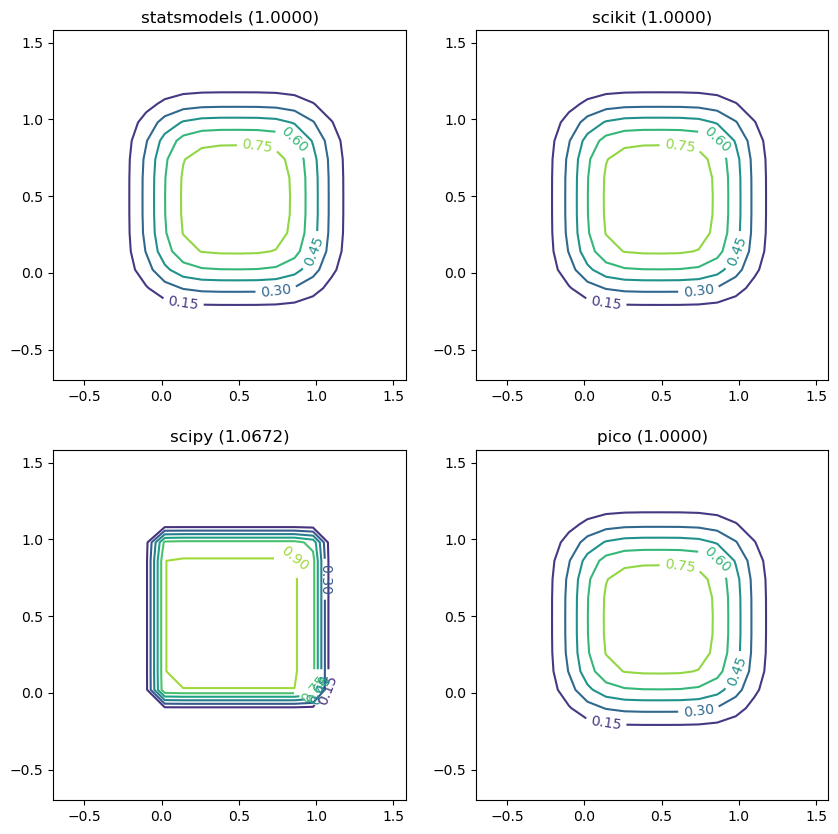

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
npoints = len(segment)
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
for idx, row in df[df.dim == 2].reset_index().iterrows():
    ax = axes[idx // 2, idx % 2]
    cs = ax.contour(segment, segment, np.exp(row.logd).reshape(npoints, npoints))
    ax.clabel(cs, inline=True)
    # ax.imshow(row.logd.reshape(npoints, npoints))
    ax.set_title(f"{row.method} ({row.p:.4f})")  # Add title to each panel
plt.show()


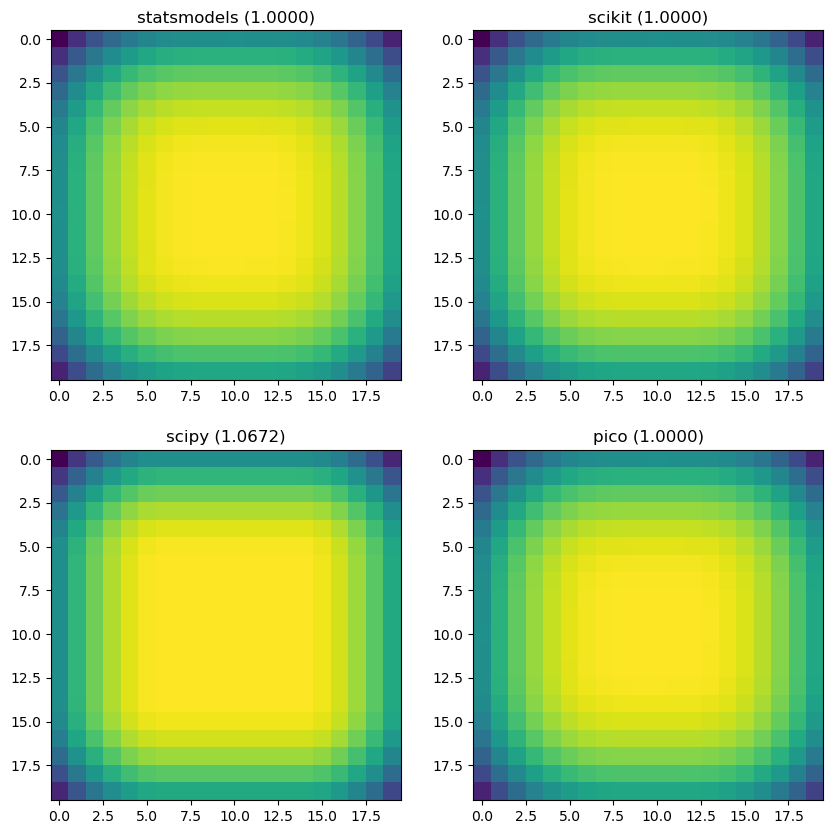

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
npoints = len(segment)
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
for idx, row in df[df.dim == 2].reset_index().iterrows():
    ax = axes[idx // 2, idx % 2]
    ax.imshow(row.logd.reshape(npoints, npoints))
    ax.set_title(f"{row.method} ({row.p:.4f})")  # Add title to each panel
plt.show()


In [16]:
ddd = df[df.dim == 3]
ddd.logd.apply(np.sum)


8     -65594.510
9     -65594.510
10   -508758.663
11    -65594.510
Name: logd, dtype: float64

In [17]:
ddd.logd.apply(lambda x: np.percentile(x, [0.05, 0.25, 0.5, 0.75, 0.9]).round(3))


8         [-29.455, -26.979, -25.038, -23.958, -23.551]
9         [-29.455, -26.979, -25.038, -23.958, -23.551]
10    [-267.798, -242.437, -222.932, -211.23, -207.329]
11        [-29.455, -26.979, -25.038, -23.958, -23.551]
Name: logd, dtype: object

In [18]:
X = load_iris(return_X_y=True)[0][:, [0, 1]] # Keep first two columns of X only
n, dim = X.shape
bw = 0.2
iris_results = []
print(n, dim, X[0])
estimators = {
    "statsmodels": KDEMultivariate(data=X, var_type="c" * dim, bw=[bw] * dim),
    "scikit": KernelDensity(bandwidth=bw).fit(X),
    "scipy": gaussian_kde(X.T, bw_method=bw),
    "pico": PicoKDE(bandwidth=bw).fit(X),
}
log_dens = {k: est.predict(X).round(3) for k, est in estimators.items()}
iris_results.extend(
    {
        "dim": dim,
        "method": name,
        # Aquí la grilla no es rectangular así que no se puede "integrar"
        # "p": sum(np.exp(logd) * (step**dim)),
        "logd": logd,
    }
    for name, logd in log_dens.items()
)


150 2 [5.1 3.5]


In [19]:
pd.DataFrame(iris_results)

,dim,method,logd
0,2,statsmodels,"[-0.946, -1.365, -1.207, -1.424, -1.071, -1.87..."
1,2,scikit,"[-0.946, -1.365, -1.207, -1.424, -1.071, -1.87..."
2,2,scipy,"[-0.562, -0.936, -0.967, -1.096, -0.977, -1.66..."
3,2,pico,"[-0.946, -1.365, -1.207, -1.424, -1.071, -1.87..."


In [20]:
xs = np.linspace(X[:, 0].min() * 0.95, X[:, 0].max() * 1.05, 30)
ys = np.linspace(X[:, 1].min() * 0.95, X[:, 1].max() * 1.05, 30)
xx, yy = np.meshgrid(xs, ys)
X_test = np.array(list(zip(xx.ravel(), yy.ravel())))


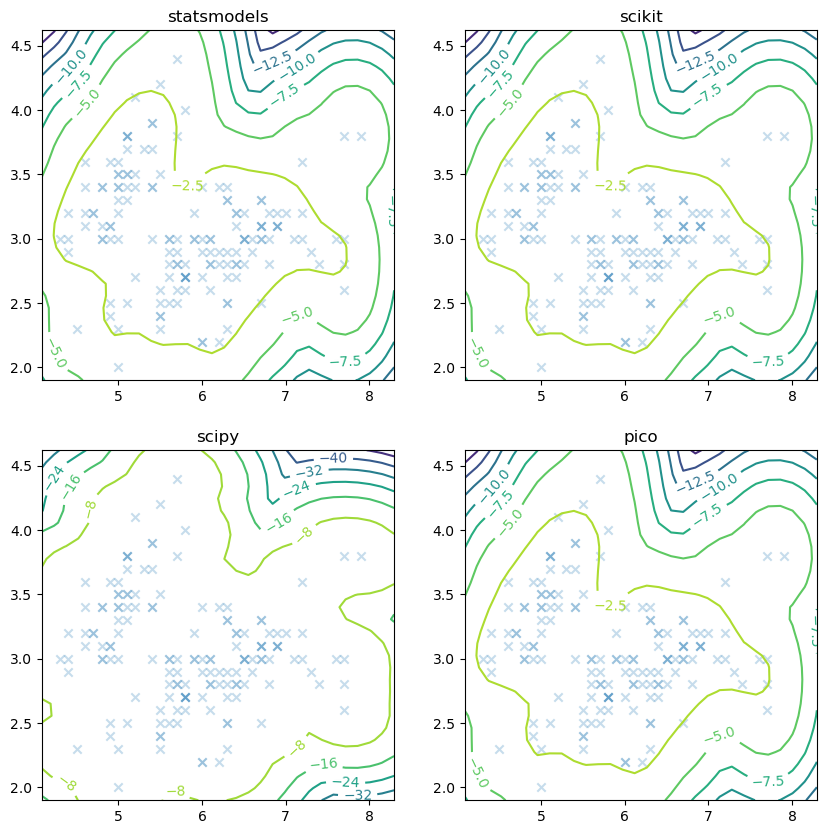

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
npoints = len(segment)
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
for idx, row in pd.DataFrame(iris_results).iterrows():
    ax = axes[idx // 2, idx % 2]
    zz = estimators[row.method].predict(X_test).reshape(len(xx), len(yy))
    cs = ax.contour(xx, yy, zz)
    ax.clabel(cs, inline=True)
    ax.scatter(X[:, 0], X[:, 1], marker='x', alpha=0.25)
    ax.set_title(row.method)  # Add title to each panel
plt.show()


In [22]:
np.cov(X, rowvar=False)

array([[ 0.68569351, -0.042434  ],
       [-0.042434  ,  0.18997942]])

In [23]:
# Invert X's covariance matrix
X_cov_inv = np.linalg.inv(np.cov(X, rowvar=False))
X_cov_inv_sqrt = sp.linalg.sqrtm(X_cov_inv)

In [24]:
# Whiten data and redo
X @ X_cov_inv_sqrt.T
np.cov(X @ X_cov_inv_sqrt.T, rowvar=False).round(5)

array([[ 1., -0.],
       [-0.,  1.]])

In [25]:
X = X @ X_cov_inv_sqrt.T

In [26]:
whitened_iris_results = []
print(n, dim, X[0])
estimators = {
    "statsmodels": KDEMultivariate(data=X, var_type="c" * dim, bw=[bw] * dim),
    "scikit": KernelDensity(bandwidth=bw).fit(X),
    "scipy": gaussian_kde(X.T, bw_method=bw),
    "pico": PicoKDE(bandwidth=bw).fit(X),
}
log_dens = {k: est.predict(X) for k, est in estimators.items()}
whitened_iris_results.extend(
    {
        "dim": dim,
        "method": name,
        # "p": sum(np.exp(logd) * (xstep * ystep)),
        "logd": logd,
    }
    for name, logd in log_dens.items()
)


150 2 [6.51181305 8.55785644]


In [27]:
df = pd.DataFrame(whitened_iris_results)
df["score"] = df.logd.apply(sum)
assert np.allclose(df.score, df.score[0])
df

,dim,method,logd,score
0,2,statsmodels,"[-1.588415881218944, -1.9619348049336067, -1.9...",-332.275958
1,2,scikit,"[-1.5884158812189457, -1.9619348049336054, -1....",-332.275958
2,2,scipy,"[-1.5884158812189448, -1.9619348049336065, -1....",-332.275958
3,2,pico,"[-1.588415881218944, -1.9619348049336067, -1.9...",-332.275958


In [28]:
sigmax, sigmay = np.sqrt(np.var(X, axis=0))
xmin, xmax = X[:, 0].min(), X[:, 0].max()
ymin, ymax = X[:, 1].min(), X[:, 1].max()
npoints = 30
xs = np.linspace(xmin - sigmax, xmax + sigmax, 50)
ys = np.linspace(ymin - sigmay, ymax + sigmay, 50)
xx, yy = np.meshgrid(xs, ys)
xstep = xs[1] - xs[0]
ystep = ys[1] - ys[0]
X_test = np.array(list(zip(xx.ravel(), yy.ravel())))


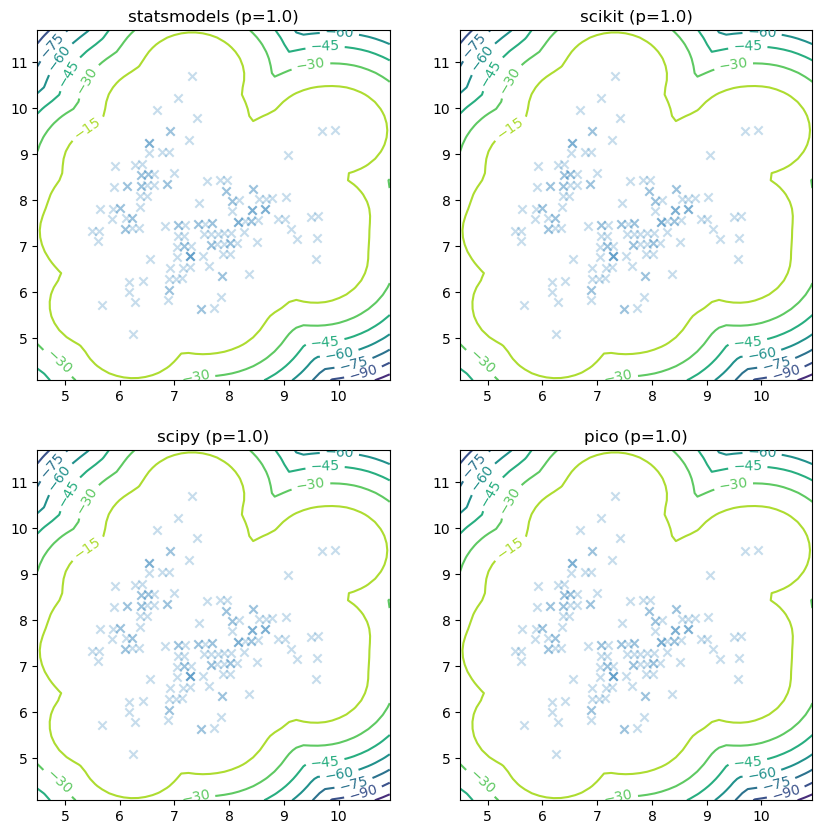

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
probs = {}
for idx, row in pd.DataFrame(whitened_iris_results).iterrows():
    ax = axes[idx // 2, idx % 2]
    zz = estimators[row.method].predict(X_test).reshape(len(xx), len(yy))
    p = probs[idx] = np.sum(np.exp(zz) * (xstep * ystep))
    cs = ax.contour(xx, yy, zz)
    ax.clabel(cs, inline=True)
    ax.scatter(X[:, 0], X[:, 1], marker='x', alpha=0.25)
    ax.set_title(f"{row.method} (p={p.round(6)})")  # Add title to each panel
plt.show()


In [30]:
df["p"] = probs
assert np.allclose(df.p, 1)
df

,dim,method,logd,score,p
0,2,statsmodels,"[-1.588415881218944, -1.9619348049336067, -1.9...",-332.275958,1.0
1,2,scikit,"[-1.5884158812189457, -1.9619348049336054, -1....",-332.275958,1.0
2,2,scipy,"[-1.5884158812189448, -1.9619348049336065, -1....",-332.275958,1.0
3,2,pico,"[-1.588415881218944, -1.9619348049336067, -1.9...",-332.275958,1.0


## Computo Distancia euclidea

In [31]:
# Import distance_matrix and pairwise distances
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.spatial import distance_matrix
from sklearn.metrics import pairwise_distances, euclidean_distances

In [32]:
# X = load_iris(return_X_y=True)[0][:, [0, 1]] # Keep first two columns of X only
# X = mvn(mean=[0] * 20).rvs(size=10000)
X = lattice(0, 5, 1, dim=3)

In [33]:
assert np.all(squareform(pdist(X, metric="euclidean")) == distance_matrix(X, X, p=2))


In [ ]:
%%timeit
pdist(X, metric="euclidean")

In [ ]:
%%timeit
squareform(pdist(X, metric="euclidean"))

In [ ]:
%%timeit
distance_matrix(X, X, p=2)

In [ ]:
%%timeit
pairwise_distances(X, metric="euclidean")

In [ ]:
%%timeit
euclidean_distances(X)

Vamos con `pdist` que es consistentemente la mejorcita

In [34]:
def euclidean(X, Y=None):
    if Y is None:
        return squareform(pdist(X, metric="euclidean"))
    else:
        return cdist(X, Y, metric="euclidean")
    

def power_euclidean(X, Y=None, p=2):
    _euclidean = euclidean(X, Y)
    return _euclidean ** p

def scalar_euclidean(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

## FermatKDE

In [35]:
class FermatKDE:
    def __init__(self, alpha=1, bandwidth=1):
        self.alpha = alpha
        self.bandwitdh = bandwidth

    def fit(self, X):
        self.X_ = X
        self.euclidean_dists_ = euclidean(X)
        self.fermat_ = Fermat(alpha=self.alpha, path_method="FW").fit(
            self.euclidean_dists_
        )
        self.fermat_dists_ = self.fermat_.get_distances()
        self.n_, self.dim_ = X.shape
        return self

    def density(self, log=True):
        densities = (
            (self.bandwitdh**-self.dim_)
            * (2 * np.pi) ** (-self.dim_ / 2)
            * np.exp(-1 / 2 * (self.fermat_dists_ / self.bandwitdh) ** 2).mean(axis=1)
        )
        return np.log(densities) if log else densities


In [36]:
# X = lattice(0, 3, 1, dim=2)
X = load_iris(return_X_y=True)[0][:, :2]
# Agrego un poco de ruido para "despegar" las observaciones repetidas que confunden a fermat.Fermat
X += np.random.normal(0, 0.0001, size=X.shape)
# X = mvn(mean=[0] * 20).rvs(size=10000)
X.shape

(150, 2)

In [37]:
%%timeit
FermatKDE(alpha=1, bandwidth=1).fit(X)

5.95 ms ± 99.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
%%timeit
PicoKDE(bandwidth=1).fit(X)

444 ns ± 11.5 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [39]:
%%timeit
FermatKDE(alpha=1, bandwidth=1).fit(X).density()

6.17 ms ± 89.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
%%timeit
PicoKDE(bandwidth=1).fit(X).density(X)

18.8 ms ± 878 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
fermat = FermatKDE(alpha=1, bandwidth=1).fit(X)
f_dens = fermat.density()
e_dens = PicoKDE(bandwidth=1).fit(X).density(X)
assert np.allclose(f_dens, e_dens)

In [42]:
FermatKDE.predict = lambda self, X: self.density()  # Parche

# X = load_iris(return_X_y=True)[0][:, [0, 1]] # Keep first two columns of X only
# # `Fermat` no lidia bien con distancias entre puntos repetidos
# # Add random gaussian noise to X to avoid issues with repeated points
# X += np.random.normal(0, 0.0001, size=X.shape)
X, y = make_moons(n_samples=1000, noise=0.1)

n, dim = X.shape
bw = np.random.uniform(0, 1)
results = []
print(n, dim, X[0])
estimators = {
    "statsmodels": KDEMultivariate(data=X, var_type="c" * dim, bw=[bw] * dim),
    "scikit": KernelDensity(bandwidth=bw).fit(X),
    "scipy": gaussian_kde(X.T, bw_method=bw),
    "pico": PicoKDE(bandwidth=bw).fit(X),
    "Fermat (alpha=1)": FermatKDE(alpha=1, bandwidth=bw).fit(X),
    "Fermat (alpha=1.25)": FermatKDE(alpha=1.25, bandwidth=bw).fit(X),
    "Fermat (alpha=1.5)": FermatKDE(alpha=1.5, bandwidth=bw).fit(X),
    "Fermat (alpha=2)": FermatKDE(alpha=2, bandwidth=bw).fit(X),
}
log_dens = {k: est.predict(X).round(3) for k, est in estimators.items()}
results.extend(
    {
        "dim": dim,
        "method": name,
        # "p": sum(np.exp(logd) * (step**dim)),
        "logd": logd,
    }
    for name, logd in log_dens.items()
)


1000 2 [ 0.82759374 -0.47296214]


In [43]:
df = pd.DataFrame(results)
df["score"] = df.logd.apply(sum)
df

,dim,method,logd,score
0,2,statsmodels,"[-0.183, -1.094, -1.063, -1.169, -0.469, -0.58...",-795.024
1,2,scikit,"[-0.183, -1.094, -1.063, -1.169, -0.469, -0.58...",-795.024
2,2,scipy,"[0.102, -1.284, -0.971, -1.128, -0.152, -0.551...",-542.782
3,2,pico,"[-0.183, -1.094, -1.063, -1.169, -0.469, -0.58...",-795.024
4,2,Fermat (alpha=1),"[-0.183, -1.094, -1.063, -1.169, -0.469, -0.58...",-795.024
5,2,Fermat (alpha=1.25),"[0.874, 0.366, 0.467, 0.256, 0.63, 0.608, 0.17...",350.858
6,2,Fermat (alpha=1.5),"[1.846, 1.609, 1.613, 1.504, 1.666, 1.669, 1.2...",1476.217
7,2,Fermat (alpha=2),"[3.465, 3.318, 3.272, 3.314, 3.278, 3.204, 2.8...",3207.204


In [44]:
assert np.allclose(
    PicoKDE(bandwidth=bw).fit(X).density(X),
    FermatKDE(alpha=1, bandwidth=bw).fit(X).density(),
)


In [45]:
a = FermatKDE(alpha=1, bandwidth=bw).fit(X)

In [46]:
assert np.allclose(a.fermat_dists_, a.euclidean_dists_)

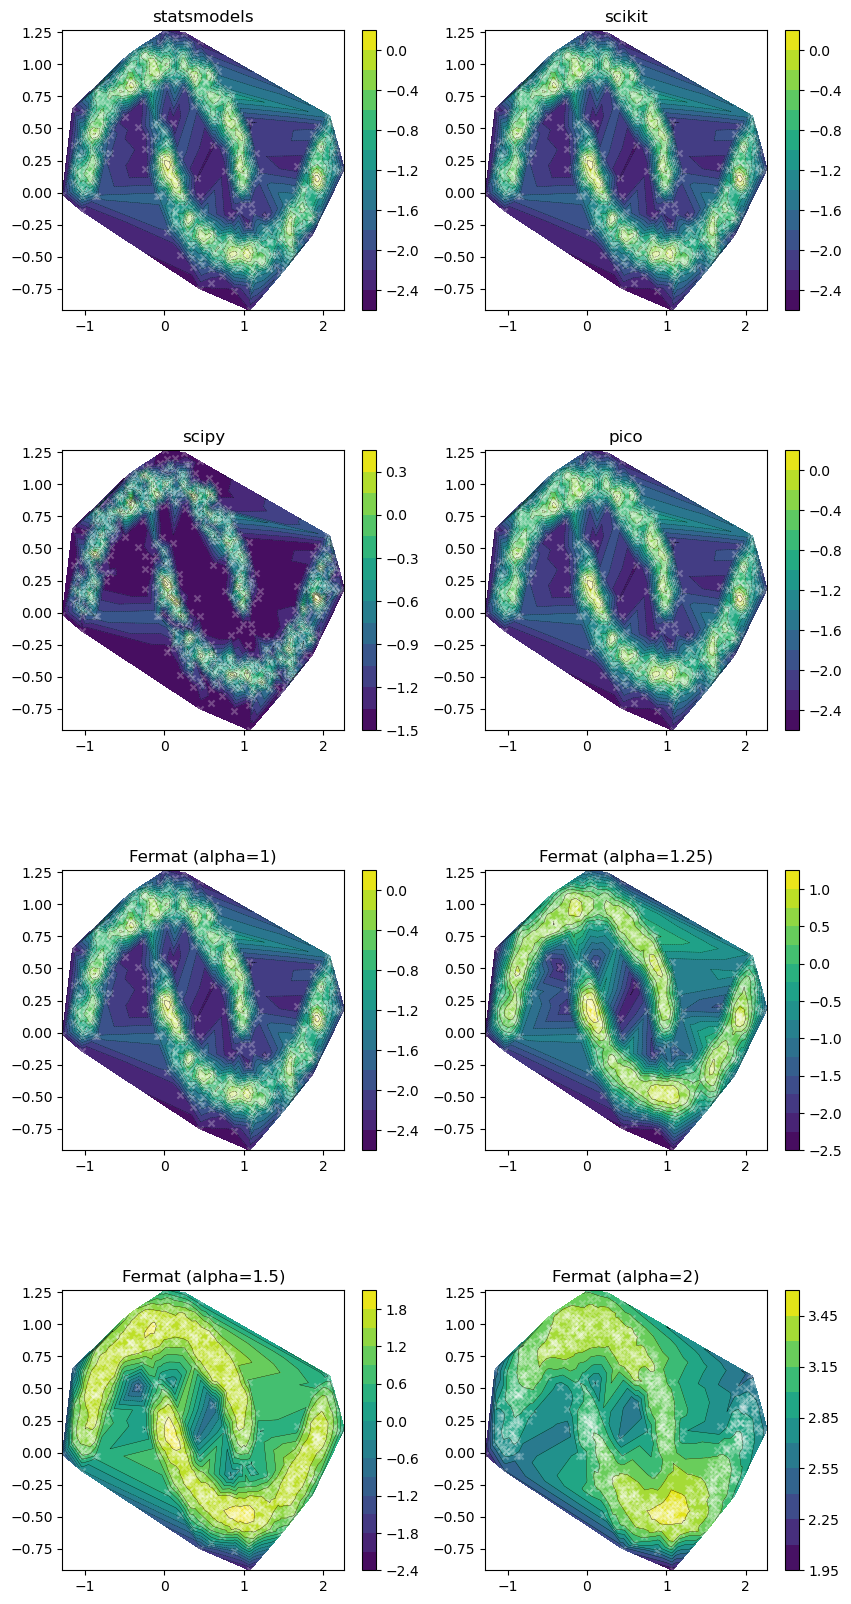

In [47]:
x, y = X[:, 0], X[:, 1]
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
for idx, row in pd.DataFrame(results).iterrows():
    ax = axes[idx // 2, idx % 2]
    z = row.logd
    ax.tricontour(x, y, z, levels=14, linewidths=0.25, colors='k')
    cntr = ax.tricontourf(x, y, z, levels=14, cmap='viridis')
    fig.colorbar(cntr, ax=ax)
    ax.scatter(x, y, marker="x", color="white", alpha=0.25, s=20)    
    ax.set_title(row.method)

plt.subplots_adjust(hspace=0.5)
plt.show()


## Out-Of-Sample Fermat KDE

In [48]:
class OOSFermatKDE:
    def __init__(self, alpha=1, bandwidth=1):
        self.alpha = alpha
        self.bandwidth = bandwidth

    def fit(self, X):
        self.X_ = X
        self.euclidean_dists_ = euclidean(X)
        self.fermat_ = Fermat(alpha=self.alpha, path_method="FW").fit(
            self.euclidean_dists_
        )
        self.fermat_dists_ = self.fermat_.get_distances()
        self.n_, self.dim_ = X.shape
        return self

    def _dist_to_edge(self, X_from):
        return np.array(
            [
                [((x_from - x_to) ** 2).sum() ** (self.alpha / 2) for x_to in self.X_]
                for x_from in X_from
            ]
        )

    def _distances(self, X_from):
        to_edge = self._dist_to_edge(X_from)
        dists = np.zeros((X_from.shape[0], self.n_))
        for i, x_from in enumerate(X_from):
            dists[i, :] = np.min(to_edge[i].T + self.fermat_dists_, axis=1)
        return dists

    def density(self, X, log=True):
        densities = (
            (self.bandwidth**-self.dim_)
            * (2 * np.pi) ** (-self.dim_ / 2)
            * np.exp(-1 / 2 * (self._distances(X) / self.bandwidth) ** 2).mean(axis=1)
        )
        return np.log(densities) if log else densities


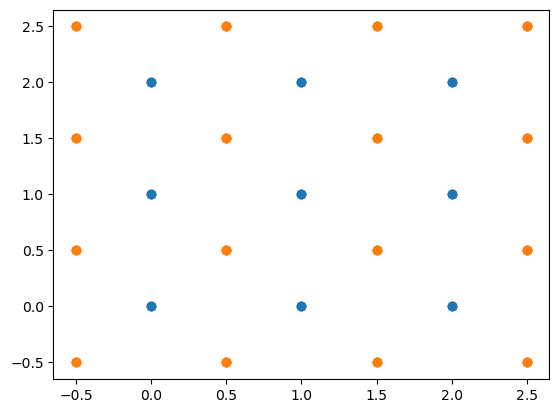

In [49]:
dim = 3
X_train = lattice(0, 3, 1, dim)
X_test = lattice(-0.5, 3.5, 1, dim)
plt.scatter(X_train[:, 0], X_train[:, 1])
plt.scatter(X_test[:, 0], X_test[:, 1])
oosf = OOSFermatKDE(alpha=1, bandwidth=2).fit(X_train)

In [50]:
assert np.all(oosf._dist_to_edge(X_test).min(axis=1) == 0.5 * np.sqrt(dim))

In [51]:
bw = np.random.uniform(0, 2)
isfermat = FermatKDE(alpha=1, bandwidth=bw).fit(X_train)
oosfermat = OOSFermatKDE(alpha=1, bandwidth=bw).fit(X_train)
pico = PicoKDE(bandwidth=bw).fit(X_train)
sk = KernelDensity(bandwidth=bw).fit(X_train)

In [52]:
# OOSFermat matchea in-sample Fermat cuando X_test == X_train
assert np.allclose(oosfermat.density(oosfermat.X_), isfermat.density())
# OOSFermat matchea PicoKDE cuando alfa = 1
assert np.allclose(oosfermat.density(X_test), pico.density(X_test))
# OOSFermat matchea KernelDensity cuando alfa = 1
assert np.allclose(oosfermat.density(X_test), sk.score_samples(X_test))

In [53]:
# Create a complete graph G with one node for each row of dataset X, and edges weighted by the euclidean distance between nodes
# First, import the necessary libraries
import networkx as nx
G = nx.from_numpy_matrix(euclidean(X_train))


In [54]:
OOSFermatKDE.predict = OOSFermatKDE.density  # Parche

X = load_iris(return_X_y=True)[0][:, [0, 1]] # Keep first two columns of X only
# `Fermat` no lidia bien con distancias entre puntos repetidos
# Add random gaussian noise to X to avoid issues with repeated points
X += np.random.normal(0, 0.0001, size=X.shape)
# X = make_moons(n_samples=1000, noise=0.1)[0]

n, dim = X.shape
bw = 0.27
iris_results = []
print(n, dim, X[0])
estimators = {
    "statsmodels": KDEMultivariate(data=X, var_type="c" * dim, bw=[bw] * dim),
    "scikit": KernelDensity(bandwidth=bw).fit(X),
    "scipy": gaussian_kde(X.T, bw_method=bw),
    "pico": PicoKDE(bandwidth=bw).fit(X),
    "OOSFermat (alpha=1)": OOSFermatKDE(alpha=1, bandwidth=bw).fit(X),
    "OOSFermat (alpha=1.25)": OOSFermatKDE(alpha=1.25, bandwidth=bw).fit(X),
    "OOSFermat (alpha=1.5)": OOSFermatKDE(alpha=1.5, bandwidth=bw).fit(X),
    "OOSFermat (alpha=2)": OOSFermatKDE(alpha=2, bandwidth=bw).fit(X),
}
log_dens = {k: est.predict(X).round(3) for k, est in estimators.items()}
iris_results.extend(
    {
        "dim": dim,
        "method": name,
        # "p": sum(np.exp(logd) * (step**dim)),
        "logd": logd,
    }
    for name, logd in log_dens.items()
)


150 2 [5.10007469 3.50014302]


In [55]:
df = pd.DataFrame(iris_results)
df

,dim,method,logd
0,2,statsmodels,"[-1.212, -1.523, -1.406, -1.611, -1.306, -1.95..."
1,2,scikit,"[-1.212, -1.523, -1.406, -1.611, -1.306, -1.95..."
2,2,scipy,"[-0.819, -1.24, -1.119, -1.202, -1.088, -1.848..."
3,2,pico,"[-1.212, -1.523, -1.406, -1.611, -1.306, -1.95..."
4,2,OOSFermat (alpha=1),"[-1.212, -1.523, -1.406, -1.611, -1.306, -1.95..."
5,2,OOSFermat (alpha=1.25),"[-0.836, -0.963, -1.01, -1.162, -0.893, -1.445..."
6,2,OOSFermat (alpha=1.5),"[-0.463, -0.45, -0.602, -0.702, -0.52, -0.899,..."
7,2,OOSFermat (alpha=2),"[0.231, 0.289, 0.198, 0.142, 0.192, 0.029, 0.0..."


In [56]:
np.cov(X, rowvar=False)

array([[ 0.68568282, -0.04242936],
       [-0.04242936,  0.18998329]])

In [57]:
sigmax, sigmay = np.sqrt(np.var(X, axis=0))
xmin, xmax = X[:, 0].min(), X[:, 0].max()
ymin, ymax = X[:, 1].min(), X[:, 1].max()
npoints = 35
margin = 1  # In units of standard deviation
xs = np.linspace(xmin - margin * sigmax, xmax + margin * sigmax, npoints)
ys = np.linspace(ymin - margin * sigmay, ymax + margin * sigmay, npoints)
xx, yy = np.meshgrid(xs, ys)
xstep = xs[1] - xs[0]
ystep = ys[1] - ys[0]
X_test = np.array(list(zip(xx.ravel(), yy.ravel())))


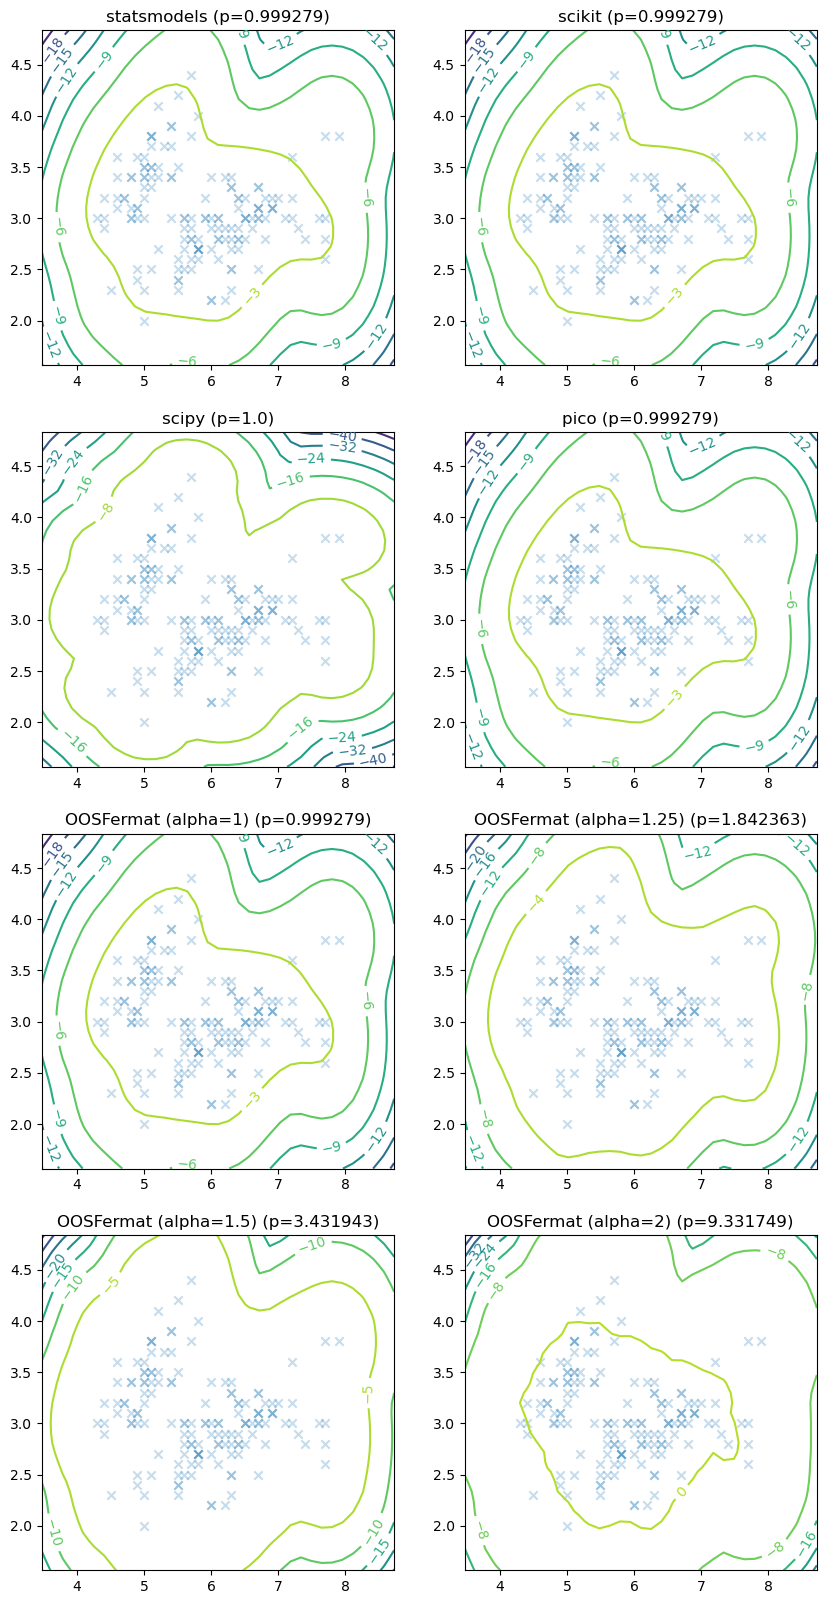

In [58]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
probs = {}
for idx, row in df.iterrows():
    ax = axes[idx // 2, idx % 2]
    zz = estimators[row.method].predict(X_test).reshape(len(xx), len(yy))
    p = probs[idx] = np.sum(np.exp(zz) * (xstep * ystep))
    cs = ax.contour(xx, yy, zz)
    ax.clabel(cs, inline=True)
    ax.scatter(X[:, 0], X[:, 1], marker='x', alpha=0.25)
    ax.set_title(f"{row.method} (p={p.round(6)})")  # Add title to each panel
plt.show()


## Moons

In [ ]:
X, y = make_moons(n_samples=600, noise=0.1)
X = X[y==0]  # Keep only one moon

n, dim = X.shape
bw = 0.27
moon_results = []
print(n, dim, X[0])
estimators = {
    "statsmodels": KDEMultivariate(data=X, var_type="c" * dim, bw=[bw] * dim),
    "scikit": KernelDensity(bandwidth=bw).fit(X),
    "scipy": gaussian_kde(X.T, bw_method=bw),
    "pico": PicoKDE(bandwidth=bw).fit(X),
    "OOSFermat (alpha=1)": OOSFermatKDE(alpha=1, bandwidth=bw).fit(X),
    "OOSFermat (alpha=1.25)": OOSFermatKDE(alpha=1.25, bandwidth=bw).fit(X),
    "OOSFermat (alpha=1.5)": OOSFermatKDE(alpha=1.5, bandwidth=bw).fit(X),
    "OOSFermat (alpha=2)": OOSFermatKDE(alpha=2, bandwidth=bw).fit(X),
}
log_dens = {k: est.predict(X).round(3) for k, est in estimators.items()}
moon_results.extend(
    {
        "dim": dim,
        "method": name,
        # "p": sum(np.exp(logd) * (step**dim)),
        "logd": logd,
    }
    for name, logd in log_dens.items()
)


In [ ]:
df = pd.DataFrame(moon_results)
df["score"] = df.logd.apply(sum)
df

### Comparando scores para diferentes $\alpha$

In [ ]:
data = [(r["method"], np.exp(r["logd"][i]), i) for r in moon_results for i in range(n)]

# Create the DataFrame
ddf = pd.DataFrame(data, columns=['method', 'score', 'index'])
ddf

In [ ]:
ddf.pivot("index", "method", "score").sort_values("OOSFermat (alpha=1.5)").reset_index().drop(columns="index").plot()

In [ ]:
ddf.groupby("method")["score"].describe()

In [ ]:
ddf["norm_score"] = ddf.groupby("method").score.transform(lambda x: x/x.sum())

In [ ]:
ddf.groupby("method").norm_score.describe()

In [ ]:
sigmax, sigmay = np.sqrt(np.var(X, axis=0))
xmin, xmax = X[:, 0].min(), X[:, 0].max()
ymin, ymax = X[:, 1].min(), X[:, 1].max()
npoints = 35
margin = 1  # In units of standard deviation
xs = np.linspace(xmin - margin * sigmax, xmax + margin * sigmax, npoints)
ys = np.linspace(ymin - margin * sigmay, ymax + margin * sigmay, npoints)
xx, yy = np.meshgrid(xs, ys)
xstep = xs[1] - xs[0]
ystep = ys[1] - ys[0]
X_test = np.array(list(zip(xx.ravel(), yy.ravel())))


In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
probs = {}
for idx, row in df.iterrows():
    ax = axes[idx // 2, idx % 2]
    zz = estimators[row.method].predict(X_test).reshape(len(xx), len(yy))
    p = probs[idx] = np.sum(np.exp(zz) * (xstep * ystep))
    cs = ax.contour(xx, yy, zz)
    ax.clabel(cs, inline=True)
    ax.scatter(X[:, 0], X[:, 1], marker='x', alpha=0.25)
    ax.set_title(f"{row.method} (p={p.round(6)})")  # Add title to each panel
plt.show()


### White Moons

In [ ]:
# Invert X's covariance matrix
X_cov_inv = np.linalg.inv(np.cov(X, rowvar=False))
X_cov_inv_sqrt = sp.linalg.sqrtm(X_cov_inv)

In [ ]:
# Whiten data and redo
X @ X_cov_inv_sqrt.T
np.cov(X @ X_cov_inv_sqrt.T, rowvar=False).round(5)

In [ ]:
X = X @ X_cov_inv_sqrt.T

In [ ]:
n, dim = X.shape
bw = 0.27
whitened_moon_results = []
print(n, dim, X[0])
estimators = {
    "statsmodels": KDEMultivariate(data=X, var_type="c" * dim, bw=[bw] * dim),
    "scikit": KernelDensity(bandwidth=bw).fit(X),
    "scipy": gaussian_kde(X.T, bw_method=bw),
    "pico": PicoKDE(bandwidth=bw).fit(X),
    "OOSFermat (alpha=1)": OOSFermatKDE(alpha=1, bandwidth=bw).fit(X),
    "OOSFermat (alpha=1.25)": OOSFermatKDE(alpha=1.25, bandwidth=bw).fit(X),
    "OOSFermat (alpha=1.5)": OOSFermatKDE(alpha=1.5, bandwidth=bw).fit(X),
    "OOSFermat (alpha=2)": OOSFermatKDE(alpha=2, bandwidth=bw).fit(X),
}
log_dens = {k: est.predict(X).round(3) for k, est in estimators.items()}
whitened_moon_results.extend(
    {
        "dim": dim,
        "method": name,
        # "p": sum(np.exp(logd) * (step**dim)),
        "logd": logd,
    }
    for name, logd in log_dens.items()
)


In [ ]:
df = pd.DataFrame(whitened_moon_results)
df["score"] = df.logd.apply(sum)
df

In [ ]:
sigmax, sigmay = np.sqrt(np.var(X, axis=0))
xmin, xmax = X[:, 0].min(), X[:, 0].max()
ymin, ymax = X[:, 1].min(), X[:, 1].max()
npoints = 35
margin = 1  # In units of standard deviation
xs = np.linspace(xmin - margin * sigmax, xmax + margin * sigmax, npoints)
ys = np.linspace(ymin - margin * sigmay, ymax + margin * sigmay, npoints)
xx, yy = np.meshgrid(xs, ys)
xstep = xs[1] - xs[0]
ystep = ys[1] - ys[0]
X_test = np.array(list(zip(xx.ravel(), yy.ravel())))


In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
probs = {}
for idx, row in df.iterrows():
    ax = axes[idx // 2, idx % 2]
    zz = estimators[row.method].predict(X_test).reshape(len(xx), len(yy))
    p = probs[idx] = np.sum(np.exp(zz) * (xstep * ystep))
    cs = ax.contour(xx, yy, zz)
    ax.clabel(cs, inline=True)
    ax.scatter(X[:, 0], X[:, 1], marker='x', alpha=0.25)
    ax.set_title(f"{row.method} (p={p.round(6)})")  # Add title to each panel
plt.show()


In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20), sharex=True, sharey=True)
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
probs = {}
for idx, row in df.iterrows():
    ax = axes[idx // 2, idx % 2]
    zz = estimators[row.method].predict(X_test).reshape(len(xx), len(yy))
    p = probs[idx] = np.sum(np.exp(zz) * (xstep * ystep))
    im = ax.imshow(
        np.exp(zz) / np.exp(zz).sum(),
        origin="lower",
        extent=[xx.min(), xx.max(), yy.min(), yy.max()],
        vmin=0, vmax=0.01,
    )
    fig.colorbar(im, ax=ax)
    # cs = ax.contour(xx, yy, zz)
    # ax.clabel(cs, inline=True)
    ax.scatter(X[:, 0], X[:, 1], marker="x", alpha=0.1, color="white")
    ax.set_title(f"{row.method} (p={p.round(6)})")  # Add title to each panel
# fig.subplots_adjust(bottom=0.05, left=0.05, top=0.95, right=0.95, hspace=0.3, wspace=0.3)
# fig.colorbar(im, ax=axes.ravel().tolist(), orientation="horizontal", fraction=0.05)
plt.show()


In [ ]:

# Create a random 2D array
data = np.array([[x + y for x in range(20)] for y in range(20)])

# Create a figure with a grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))

# Define a list of colormaps to use
cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'gray', 'cool', 'hot', 'bone', 'spring', 'summer', 'tab20c']

# Loop over each subplot and display the data with a different colormap
for i, cmap in enumerate(cmaps):
    ax = axs.flat[i]
    cmap = plt.cm.get_cmap(cmap)
    im = ax.imshow(data, cmap=cmap, origin="lower")
    ax.set_title(cmap.name)

# Adjust the spacing between subplots
fig.tight_layout()

# Display the figure
plt.show()

## KernelDensity w/ custom metrics
### Sanity check: euclidean distance

In [ ]:
%%timeit
KernelDensity(bandwidth=0.27, metric="pyfunc", metric_params={"func": scalar_euclidean}).fit(X)

In [ ]:
%%timeit
KernelDensity(bandwidth=0.27).fit(X)

In [ ]:
custom = KernelDensity(bandwidth=0.27, metric="pyfunc", metric_params={"func": scalar_euclidean}).fit(X)
standard = KernelDensity(bandwidth=0.27).fit(X)

In [ ]:
%%timeit
custom.score_samples(X)

In [ ]:
%%timeit
standard.score_samples(X)

In [ ]:
# assert np.allclose(custom.score_samples(X), standard.score_samples(X))
assert np.allclose(custom.score_samples(X_test), standard.score_samples(X_test))

In [ ]:
farthest = np.abs(custom.score_samples(X_test)- standard.score_samples(X_test)).argmax()
farthest

In [ ]:
X_test[farthest], custom.score_samples([X_test[farthest]]), standard.score_samples([X_test[farthest]])

100 veces mas lento! Mamita... al menos sabemos que parece funcionar.

### KernelDensity w/ Fermat Distance

In [ ]:
from scipy.spatial.distance import cdist


def find_row_index(X, y):
    rows_equal = np.all(X == y, axis=1)
    return np.argmax(rows_equal) if np.any(rows_equal) else -1


class FermatDistance:
    def __init__(self, X, **kwargs):
        self.alpha = kwargs.setdefault("alpha", 1)
        self.path_method = kwargs.setdefault("path_method", "FW")
        self.X = X
        self.sample_dists = Fermat(**kwargs).fit(euclidean(self.X)).get_distances()

    def __call__(self, x, y):
        # print(f"x: {x.round(3)} | y: {y.round(3)}")
        if np.allclose(x, y):
            # print("x == y")
            return 0
        # x_dists = euclidean([x], self.X)
        # min_ix = np.argmin(x_dists)
        # print(f"Closest point to x in X: {self.X[min_ix]} ({min_ix}th row)")
        # y_dists = euclidean([y], self.X)
        # min_iy = np.argmin(y_dists)
        # print(f"Closest point to x in X: {self.X[min_iy]} ({min_iy}th row)")
        ix, iy = find_row_index(self.X, x), find_row_index(self.X, y)
        if ix >= 0:  # x in X
            if iy >= 0:  # y in X
                # print("Both in X")
                return self.sample_dists[ix, iy]
            else:
                # print("x in X, y not in X")
                return self.half_distance(y, ix)
        else:  # x not in X
            if iy >= 0:  # y in X
                # print("y in X, x not in X")
                return self.half_distance(x, iy)
            else:  # y not in X
                # print("Neither in X")
                direct_dist = power_euclidean([x], [y], p=self.alpha)[0, 0]
                through_dist = self.full_distance(x, y)
                if direct_dist < through_dist:
                    # print("Direct distance is shorter")
                    return direct_dist
                else:
                    # print("Through distance is shorter")
                    return through_dist

    def half_distance(self, x, X_index):
        # Computar euclidea a la alfa desde x a todos los puntos de X
        to_X = power_euclidean([x], self.X, p=self.alpha)
        between_X = self.sample_dists[X_index]
        return np.min(to_X + between_X)

    def full_distance(self, x, y):
        # Computar euclidea a la alfa desde x a todos los puntos de X
        to_X = power_euclidean([x], self.X, p=self.alpha)
        # Computar euclidea a la alfa desde y a todos los puntos de X
        from_X = power_euclidean([y], self.X, p=self.alpha)
        return np.min(to_X + from_X)

    def _distances(self, X_from):
        to_edge = self._dist_to_edge(X_from)
        dists = np.zeros((X_from.shape[0], self.n_))
        for i, x_from in enumerate(X_from):
            dists[i, :] = np.min(to_edge[i].T + self.fermat_dists_, axis=1)
        return dists


In [ ]:
alpha = 2
fdist = FermatDistance(X, alpha=alpha)

In [ ]:
X[0]

In [ ]:
fdist(X[0], X[1]), fdist.sample_dists[0, 1]

In [ ]:
zero = np.zeros_like(X[0])
fdist(X[0], zero), fdist(zero, X[0])

In [ ]:
fdist(zero, zero), fdist(X[0], X[0]), 0

In [ ]:
epsilon = 1e-6 * np.ones_like(X[0])

In [ ]:
fdist(zero, epsilon), power_euclidean([zero], [epsilon], p=alpha)[0, 0]

In [ ]:
ten = 10 * np.ones_like(zero)
fdist(zero, ten), power_euclidean([zero], [ten], p=alpha)[0, 0]

In [ ]:
fdist.X[:3], X[:3]

In [ ]:
alpha = 2
fdist = FermatDistance(X, alpha=alpha)
kdfkde = KernelDensity(bandwidth=0.27, metric="pyfunc", metric_params={"func":fdist}).fit(X)

In [ ]:
iskde = FermatKDE(bandwidth=0.27, alpha=alpha).fit(X)
ooskde = OOSFermatKDE(bandwidth=0.27, alpha=alpha).fit(X)

In [ ]:
%%timeit
kdfkde.score_samples(X)

In [ ]:
custom = kdfkde.score_samples(X)
isstandard = iskde.density()
oosstandard = ooskde.density(X)

In [ ]:
np.allclose(custom, isstandard)

In [ ]:
np.allclose(custom, oosstandard)

In [ ]:
kdfkde = KernelDensity(bandwidth=0.27, metric="pyfunc", metric_params={"func":FermatDistance(X, alpha=alpha)}).fit(X)

In [ ]:
from time import time

X, y = make_moons(n_samples=400, noise=0.1)
X = X[y == 0]  # Keep only one moon


In [ ]:

methods = {
    "KD Custom Distance": lambda bw, alpha, X: KernelDensity(
        bandwidth=bw,
        metric="pyfunc",
        metric_params={"func": FermatDistance(X, alpha=alpha)},
    ).fit(X),
    "OOSFermat": lambda bw, alpha, X: OOSFermatKDE(alpha=alpha, bandwidth=bw).fit(X),
}
n, dim = X.shape
bw = 0.27
moon_results = []
print(n, dim, X[0])
estimators = {}
for alpha in [1, 1.25, 1.5, 2]:
    print(f"alpha={alpha}")
    for method, factory in methods.items():
        print(f"method={method}")
        t0 = time()
        est = factory(bw, alpha, X)
        fit_time = time() - t0
        t0 = time()
        log_dens = est.predict(X)
        pred_time = time() - t0
        moon_results.append(
            {
                "est": est,
                "method": method,
                "alpha": alpha,
                "bw": bw,
                "n": n,
                "fit_time": fit_time,
                "pred_time": pred_time,
                "dim": dim,
                "p": sum(np.exp(log_dens) * (step**dim)),
                "logd": log_dens,
            }
        )


In [ ]:
df = pd.DataFrame(moon_results)
df["score"] = df.logd.apply(sum)
df[["method", "alpha", "fit_time", "pred_time", "p", "score"]]

In [ ]:
n, dim

In [ ]:
df["beta"] = (df.alpha - 1) / dim
df["fact"] = n ** df.beta
df.drop(columns=["est", "logd"]).round(3)

In [ ]:
sigmax, sigmay = np.sqrt(np.var(X, axis=0))
xmin, xmax = X[:, 0].min(), X[:, 0].max()
ymin, ymax = X[:, 1].min(), X[:, 1].max()
npoints = 50
margin = 2  # In units of standard deviation
xs = np.linspace(xmin - margin * sigmax, xmax + margin * sigmax, npoints)
ys = np.linspace(ymin - margin * sigmay, ymax + margin * sigmay, npoints)
xx, yy = np.meshgrid(xs, ys)
xstep = xs[1] - xs[0]
ystep = ys[1] - ys[0]
X_test = np.array(list(zip(xx.ravel(), yy.ravel())))


In [ ]:
df["zz"] = df.est.apply(lambda x: x.predict(X_test).reshape(len(xx), len(yy)))

In [ ]:
df["probs"] = df.zz.apply(lambda x: np.exp(x) * (xstep * ystep))

In [ ]:
log_min_density = -20
fig, axes = plt.subplots(4, 2, figsize=(22, 20))
# In each panel, draw a heatmap of the estimated density, showing an appropiate scale for each panel
for idx, row in df.iterrows():
    ax = axes.flat[idx]
    p = np.sum(row.probs)
    # zz = np.exp(row.zz)
    cs = ax.contour(xx, yy, np.maximum(row.zz, log_min_density), levels=20, cmap="Blues")
    ax.clabel(cs, inline=True)
    ax.scatter(X[:, 0], X[:, 1], marker='x', alpha=0.5, color="black")
    ax.set_title(f"{row.method} ($\\alpha=${row.alpha}, p={round(p, 5)})")  # Add title to each panel


plt.show()


In [ ]:
df.drop(columns=["est", "logd", "zz", "probs"]).round(3)

In [ ]:
model_selection.GridSearchCV


```python
    def density(self, X, log=True):
        densities = (
            (self.bandwidth**-self.dim_)
            * (2 * np.pi) ** (-self.dim_ / 2)
            * np.exp(-1 / 2 * (self._distances(X) / self.bandwidth) ** 2).mean(axis=1)
        )
        return np.log(densities) if log else densities
```

In [ ]:
a, b = df.alpha[4:6]

In [ ]:
a, b

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(22, 9))
for i, ax in enumerate(axs.flat):
    sk, femto = df.zz[(2 * i) : 2 * (i + 1)]
    zz = np.exp(sk) - np.exp(femto)
    im = ax.imshow(
        # np.maximum(row.zz, log_min_density),
        (zz - zz.mean()) / np.sqrt(zz.var()),
        origin="lower",
        extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    )
    ax.scatter(X[:, 0], X[:, 1], marker=".", alpha=0.05, color="red")
    fig.colorbar(im)
    zzmax = zz.max()
    ax.set_title(f"rg=[{zz.min():.2e}, {zz.max():.1e}], $\\alpha$={df.alpha.iloc[2*i]}")
# ax.set_title(f"{row.method} (p={p.round(6)})")  # Add title to each panel
# fig.subplots_adjust(bottom=0.05, left=0.05, top=0.95, right=0.95, hspace=0.3, wspace=0.3)
# fig.colorbar(im, ax=axes.ravel().tolist(), orientation="horizontal", fraction=0.05)
plt.suptitle("logd(fKD) - logd(Femto)")
plt.show()

## Espiral

In [ ]:
import cmath
vueltas = 4
n = 400

def make_spiral(n, vueltas=4, ruido=False):
    xs = np.linspace(0, 2 * np.pi * vueltas, n)
    Z = [cmath.rect(x, x) for x in xs]
    X = np.array([[z.real, z.imag] for z in Z])
    if ruido > 0:
        X *= 1 + np.random.normal(0, ruido, size=X.shape)
    return X

X= make_spiral(n, vueltas, ruido=0.05)
plt.scatter(X[:, 0], X[:, 1])

In [ ]:
methods = {
    "KD Custom Distance": lambda bw, alpha, X: KernelDensity(
        bandwidth=bw,
        metric="pyfunc",
        metric_params={"func": FermatDistance(X, alpha=alpha)},
    ).fit(X),
    "OOSFermat": lambda bw, alpha, X: OOSFermatKDE(alpha=alpha, bandwidth=bw).fit(X),
}
n, dim = X.shape
bw = 0.5
spiral_results = []
print(n, dim, X[0])
estimators = {}
for alpha in [1, 1.25, 1.5, 2]:
    print(f"alpha={alpha}")
    for method, factory in methods.items():
        print(f"method={method}")
        t0 = time()
        est = factory(bw, alpha, X)
        fit_time = time() - t0
        t0 = time()
        log_dens = est.predict(X)
        pred_time = time() - t0
        spiral_results.append(
            {
                "est": est,
                "method": method,
                "alpha": alpha,
                "bw": bw,
                "n": n,
                "fit_time": fit_time,
                "pred_time": pred_time,
                "dim": dim,
                "p": sum(np.exp(log_dens) * (step**dim)),
                "logd": log_dens,
            }
        )


In [ ]:
est = OOSFermatKDE(alpha=1.25, bandwidth=0.5).fit(X)
print(est.predict(X)[:5])
est.bandwidth = 1.0
print(est.predict(X)[:5])

In [ ]:
# import cross validation scorer and kfold cv splitter
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
def negloglikelihood(estimator, X, y=None):
    return estimator.predict(X).sum()

In [ ]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.1)

In [ ]:
alphas = [1, 1.25, 1.5, 2]
# fdists = {alpha: FermatDistance(X, alpha=alpha) for alpha in alphas}
kf = KFold(n_splits=3)
kf.get_n_splits(X)

print(kf)
results = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    for alpha in alphas:
        fermat_dist = FermatDistance(X_train, alpha=alpha)
        fermat_est = OOSFermatKDE(alpha=alpha, bandwidth=-1).fit(X_train)
        dists = fdist.sample_distsb
        mean, std = dists.mean(), dists.std()
        hs = np.linspace(mean - 3 * std, mean + 3 * std, 5)
        for h in hs:
            kd_est = KernelDensity(
                bandwidth=bw,
                metric="pyfunc",
                metric_params={"func": fdist},
            ).fit(X)
            fermat_est.bandwidth = h
            estimators = {
                "KD Custom Distance": kd_est,
                "OOSFermat": fermat_est,
            }
            for name, est in estimators.items():
                preds = est.predict(X_test)
                score = np.sum(preds)
                print(f"split={i}, alpha={alpha}, h={h}, method={name}, score={score}")
                results.append(
                    {"alpha": alpha, "h": h, "method": name, "preds": preds, "score": score}
                )


In [ ]:
df=pd.DataFrame(results).sort_values("score")

In [ ]:
df

In [ ]:
df = pd.DataFrame(spiral_results)
df["score"] = df.logd.apply(np.sum)
df[["method", "alpha", "fit_time", "pred_time", "n", "p", "score"]]


In [ ]:
sigmax, sigmay = np.sqrt(np.var(X, axis=0))
xmin, xmax = X[:, 0].min(), X[:, 0].max()
ymin, ymax = X[:, 1].min(), X[:, 1].max()
npoints = 50
margin = 0.5  # In units of standard deviation
xs = np.linspace(xmin - margin * sigmax, xmax + margin * sigmax, npoints)
ys = np.linspace(ymin - margin * sigmay, ymax + margin * sigmay, npoints)
xx, yy = np.meshgrid(xs, ys)
xstep = xs[1] - xs[0]
ystep = ys[1] - ys[0]
X_test = np.array(list(zip(xx.ravel(), yy.ravel())))


In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
probs = {}
scores = {}
ZZ = {}
for idx, row in df.iterrows():
    ax = axes[idx // 2, idx % 2]
    ZZ[idx] = zz = row.est.predict(X_test).reshape(len(xx), len(yy))
    p = probs[idx] = np.sum(np.exp(zz) * (xstep * ystep))
    scores[idx] = np.sum(zz)
    cs = ax.contour(xx, yy, zz)
    ax.clabel(cs, inline=True)
    ax.scatter(X[:, 0], X[:, 1], marker='x', alpha=0.25)
    ax.set_title(f"{row.method} (p={p.round(6)})")  # Add title to each panel
plt.show()


In [ ]:
df["test_p"] = probs
df["test_score"] = scores
df[["method", "alpha", "fit_time", "pred_time","n", "p", "score", "test_p", "test_score"]]

In [ ]:
{k: np.isinf(v).sum() for k, v in ZZ.items()}

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20), sharex=True, sharey=True)
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
probs = {}
for idx, row in df.iterrows():
    ax = axes[idx // 2, idx % 2]
    p = row.test_p
    im = ax.imshow(
        np.isfinite(ZZ[idx]),
        cmap="gray",
        origin="lower",
        extent=[xx.min(), xx.max(), yy.min(), yy.max()],
        vmin=0,
        vmax=1,
    )
    fig.colorbar(im, ax=ax)
    # cs = ax.contour(xx, yy, zz)
    # ax.clabel(cs, inline=True)
    ax.scatter(X[:, 0], X[:, 1], marker="x", alpha=0.2, color="green")
    ax.set_title(f"{row.method} (p={round(p, 5)})")  # Add title to each panel
# fig.subplots_adjust(bottom=0.05, left=0.05, top=0.95, right=0.95, hspace=0.3, wspace=0.3)
# fig.colorbar(im, ax=axes.ravel().tolist(), orientation="horizontal", fraction=0.05)
plt.show()


In [ ]:
1.78/1.65

In [ ]:
infs = np.isinf(ZZ[1])
(
    (ZZ[0][infs].min(), ZZ[0][infs].max(), ZZ[0][infs].mean()),
    (ZZ[0][~infs].min(), ZZ[0][~infs].max(), ZZ[0][~infs].mean()),

    (ZZ[1][infs].min(), ZZ[1][infs].max(), ZZ[1][infs].mean()),
    (ZZ[1][~infs].min(), ZZ[1][~infs].max(), ZZ[1][~infs].mean()),)


In [ ]:
np.isclose(0, 1e-8)

In [ ]:
for i in range(4):
    pd

In [ ]:
np.argmin(np.isinf(ZZ[1]))

In [ ]:
suspect = X_test[0]
est = df.iloc[1].est
distances = est._distances(X_test[:1, :])
h = est.bandwidth
N, d = X.shape
h, d, N, pd.Series(distances.flatten()).describe()

In [ ]:
est.alpha

In [ ]:
fd = FermatDistance(X, alpha=1)

In [ ]:
[fd(suspect, x) for x in X[:10]]

In [ ]:
first_n = 10000
np.allclose(distances.flatten()[:first_n], [fd(suspect, x) for x in X[:first_n]])

In [ ]:
df.iloc[0].est.score_samples(X_test[:1])

In [ ]:
df.iloc[1].est.density(X_test[:1])

In [ ]:
np.log(N), d * np.log(h), d / 2 * np.log(2 * np.pi), -1 / 2 * (distances / h) ** 2


In [ ]:
np.sqrt(2*745) * h

In [ ]:
- d * np.log(h)

In [ ]:
print(np.finfo(np.longdouble))

In [ ]:
epsilon = np.finfo(np.longfloat).smallest_subnormal
min_logdensity = np.log(epsilon)

In [ ]:
np.maximum(ZZ[0], min_logdensity).sum(), ZZ[0].sum()

In [ ]:
np.maximum(ZZ[1], min_logdensity).sum(), ZZ[1].sum()

In [ ]:
df.iloc[1]

In [ ]:
np.log(np.exp(-747, dtype=np.longdouble), dtype=np.longdouble)

In [ ]:
distances[distances< 20.05]

In [ ]:
np.exp(-745.126)

In [ ]:
-1 / 2 * (distances / h) ** 2


In [ ]:
((h**-d) * (2 * np.pi) ** (-d / 2) * np.exp(-1 / 2 * (distances / h) ** 2).mean(axis=1))

In [ ]:
fermat_distance = df.iloc[0].est.fer

In [ ]:
-1/2 * (distances / h)

In [ ]:
X.shape

In [ ]:
np.exp(-1 / 2 * (distances / h) ** 2)

In [ ]:
df.iloc[1].est._distances(X_test[0])

In [ ]:
df.iloc[1].est._distances(
)

In [ ]:
infs = np.isinf(ZZ[3])
ZZ[2][infs].max(), ZZ[2][~infs].min(), ZZ[3][infs].min(), ZZ[3][~infs].max()

In [ ]:
df.iloc[1].est.predict(np.array([[i/2, i/2] for i in range(10)])).round(3)

In [ ]:
df.iloc[0].est.predict(np.array([[i/2, i/2] for i in range(10)])).round(3)

In [ ]:
zpreds = ZZ[1].flatten()
fresh_preds = df.iloc[1].est.predict(X_test)

In [ ]:
assert np.all(zpreds == fresh_preds)

In [ ]:
np.isinf(fresh_preds).sum()

In [ ]:
infs = np.isinf(ZZ[1])
infs.sum()


In [ ]:
ZZ[0][infs].mean(), ZZ[0][~infs].mean()

In [ ]:
np.exp(-1100)

In [ ]:
np.isfinite(ZZ[0]).sum(), np.isinf(ZZ[0]).sum(), np.isfinite(ZZ[1]).sum(), np.isinf(ZZ[1]).sum()
# ZZ[0].shape

In [ ]:
def logsumexp(arr):
    return np.log(np.exp(arr).sum())


class LogOOSFermatKDE:
    def __init__(self, alpha=1, bandwidth=1):
        self.alpha = alpha
        self.bandwidth = bandwidth

    def fit(self, X):
        self.X_ = X
        self.euclidean_dists_ = euclidean(X)
        self.fermat_ = Fermat(alpha=self.alpha, path_method="FW").fit(
            self.euclidean_dists_
        )
        self.fermat_dists_ = self.fermat_.get_distances()
        self.n_, self.dim_ = X.shape
        return self

    def _dist_to_edge(self, X_from):
        return np.array(
            [
                [((x_from - x_to) ** 2).sum() ** (self.alpha / 2) for x_to in self.X_]
                for x_from in X_from
            ]
        )

    def _distances(self, X_from):
        to_edge = self._dist_to_edge(X_from)
        dists = np.zeros((X_from.shape[0], self.n_))
        for i, x_from in enumerate(X_from):
            dists[i, :] = np.min(to_edge[i].T + self.fermat_dists_, axis=1)
        return dists

    def density(self, X, log=True):
        log_densities = -(
            self.dim_ * np.log(self.bandwidth)
            + self.dim_ / 2 * np.log(2 * np.pi)
            + 1 / 2 * ((self._distances(X) / self.bandwidth) ** 2).mean(axis=1)
        )
        return log_densities if log else np.exp(log_densities)


In [ ]:
LogOOSFermatKDE.predict = LogOOSFermatKDE.density

methods = {
    "KD Custom Distance": lambda bw, alpha, X: KernelDensity(
        bandwidth=bw,
        metric="pyfunc",
        metric_params={"func": FermatDistance(X, alpha=alpha)},
    ).fit(X),
    "OOSFermat": lambda bw, alpha, X: OOSFermatKDE(alpha=alpha, bandwidth=bw).fit(X),
    "LogOOSFermat": lambda bw, alpha, X: LogOOSFermatKDE(alpha=alpha, bandwidth=bw).fit(
        X
    ),
}
n, dim = X.shape
bw = 2.7
spiral_results = []
print(n, dim, X[0])
estimators = {}
for alpha in [1, 1.25, 1.5, 2]:
    print(f"alpha={alpha}")
    for method, factory in methods.items():
        print(f"method={method}")
        t0 = time()
        est = factory(bw, alpha, X)
        fit_time = time() - t0
        t0 = time()
        log_dens = est.predict(X)
        pred_time = time() - t0
        spiral_results.append(
            {
                "est": est,
                "method": method,
                "alpha": alpha,
                "bw": bw,
                "n": n,
                "fit_time": fit_time,
                "pred_time": pred_time,
                "dim": dim,
                "p": sum(np.exp(log_dens) * (step**dim)),
                "logd": log_dens,
            }
        )


In [ ]:
df = pd.DataFrame(spiral_results)
df["score"] = df.logd.apply(np.sum)
df[["method", "alpha", "fit_time", "pred_time", "n", "p", "score"]]


In [ ]:
sigmax, sigmay = np.sqrt(np.var(X, axis=0))
xmin, xmax = X[:, 0].min(), X[:, 0].max()
ymin, ymax = X[:, 1].min(), X[:, 1].max()
npoints = 50
margin = 0.5  # In units of standard deviation
xs = np.linspace(xmin - margin * sigmax, xmax + margin * sigmax, npoints)
ys = np.linspace(ymin - margin * sigmay, ymax + margin * sigmay, npoints)
xx, yy = np.meshgrid(xs, ys)
xstep = xs[1] - xs[0]
ystep = ys[1] - ys[0]
X_test = np.array(list(zip(xx.ravel(), yy.ravel())))


In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(15, 20))
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
probs = {}
scores = {}
ZZ = {}
for idx, row in df.iterrows():
    ax = axes[idx // 3, idx % 3]
    ZZ[idx] = zz = row.est.predict(X_test).reshape(len(xx), len(yy))
    p = probs[idx] = np.sum(np.exp(zz) * (xstep * ystep))
    scores[idx] = np.sum(zz)
    cs = ax.contour(xx, yy, zz)
    ax.clabel(cs, inline=True)
    ax.scatter(X[:, 0], X[:, 1], marker='x', alpha=0.25)
    ax.set_title(f"{row.method} (p={p.round(6)})")  # Add title to each panel
plt.show()


In [ ]:
df["test_p"] = probs
df["test_score"] = scores
df[["method", "alpha", "fit_time", "pred_time","n", "p", "score", "test_p", "test_score"]]

In [ ]:
def logsumexp(arr):
    return np.log(np.sum(np.exp(arr)))

In [ ]:
np.exp(-745)

In [ ]:
EPSILON = 5e-324

In [ ]:
5e-324

In [ ]:
h

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20), sharex=True, sharey=True)
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
probs = {}
for idx, row in df.iterrows():
    ax = axes[idx // 2, idx % 2]
    zz = row.est.predict(X_test).reshape(len(xx), len(yy))
    p = probs[idx] = np.sum(np.exp(zz) * (xstep * ystep))
    im = ax.imshow(
        np.exp(zz) / np.exp(zz).sum(),
        origin="lower",
        extent=[xx.min(), xx.max(), yy.min(), yy.max()],
        vmin=0, vmax=0.01,
    )
    fig.colorbar(im, ax=ax)
    # cs = ax.contour(xx, yy, zz)
    # ax.clabel(cs, inline=True)
    ax.scatter(X[:, 0], X[:, 1], marker="x", alpha=0.1, color="white")
    ax.set_title(f"{row.method} (alpha={row.alpha}) (p={p.round(6)})")  # Add title to each panel
# fig.subplots_adjust(bottom=0.05, left=0.05, top=0.95, right=0.95, hspace=0.3, wspace=0.3)
# fig.colorbar(im, ax=axes.ravel().tolist(), orientation="horizontal", fraction=0.05)
plt.show()


In [ ]:
xs = np.linspace(X[:, 0].min() * 0.8, X[:, 0].max() * 1.2, 100)
ys = np.linspace(X[:, 1].min() * 0.8, X[:, 1].max() * 1.2, 100)
xx, yy = np.meshgrid(xs, ys)
X_test = np.array(list(zip(xx.ravel(), yy.ravel())))


## Old version

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [ ]:
from sklearn.datasets import load_digits
# import GridSearch
from sklearn.model_selection import GridSearchCV

digits = load_digits()

bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(digits.data, digits.target)

scores = grid.cv_results_["mean_test_score"]

In [ ]:
plt.semilogx(bandwidths, scores)
plt.xlabel("bandwidth")
plt.ylabel("accuracy")
plt.title("KDE Model Performance")
print(grid.best_params_)
print("accuracy =", grid.best_score_)


In [ ]:
grid.best_estimator_

In [ ]:
sns.scatterplot(x="n_dim", y="time", data=res)
est = LinearRegression().fit(res[["n_dim"]], res.time)
plt.title(f"time[s] = {est.intercept_.round(3)} + {est.coef_[0].round(3)} * n_dim")
plt.axline([0, est.intercept_], slope=est.coef_, linestyle="dashed", color="gray")
plt.show()


OK, también parece lineal en `n_dim`.

Los tiempos de `KernelDensity` son como la mitad de los de EuclideanKDE, pero no sé cuánto mejor/peor serían si implementase una DistanceMetric nueva para la distancia de Fermat. Por el momento, seguimos con la programacion habitual, y mantenemos los clasificadores de juguete.

In [ ]:
from sklearn.model_selection import GridSearchCV


In [ ]:
from numpy import random as rnd
import seaborn as sns


In [ ]:
A = rnd.rand(100, 3)
A.sort(axis=1)
A = np.column_stack([np.zeros_like(A[:, 0]), A, np.ones_like(A[:, 0])])
a = A[0]
a, A[
    :5,
]


In [ ]:
def fermat_dist(x, alpha=1):
    """Fermat alpha-distance between `x_0` and `x_k`, in the line graph with nodes at `x = (x_1, ..., x_k)`."""
    return ((x[1:] - x[:-1]) ** alpha).sum()


In [ ]:
np.apply_along_axis(fermat_dist, axis=1, arr=X, alpha=3).mean()


In [ ]:
sample_size = 1000
scales = [1 / 10, 1 / 2, 1, 2, 10]
alphas = np.linspace(1, 4, 7)
ks = [1, 2, 5, 10]
results = []
for k in ks:
    A = rnd.rand(sample_size, k)
    A.sort(axis=1)
    A = np.column_stack([np.zeros_like(A[:, 0]), A, np.ones_like(A[:, 0])])
    for scale in scales:
        for alpha in alphas:
            results.append(
                dict(
                    k=k,
                    alpha=alpha,
                    scale=scale,
                    dists=np.apply_along_axis(
                        fermat_dist, axis=1, arr=scale * A, alpha=alpha
                    ),
                )
            )


In [ ]:
df = pd.DataFrame(results)


In [ ]:
df["mean_dist"] = df.dists.apply(np.mean)
df["scaled_dist"] = df.mean_dist / (df.scale**df.alpha)


In [ ]:
df.head()


In [ ]:
df[df.k == 1].pivot("alpha", "scale", "mean_dist").round(3)


In [ ]:
df[df.k == 1].pivot("alpha", "scale", "scaled_dist").round(3)


Está claro que si $c$ es la constance de escale `scale`, las distancias de fermat escalan según $c^{-\alpha}$. Ahora, cuánto cambian con el tamaño de muestra $k$? 

Para $k=1$, se puede calcular exactamente la esperanza de la longitud del camino. Si hay un único punto entre 0 y 1 elegido al azar según $X \sim \text{Unif}(0, 1)$, entonces la longitud del camino de Fermat cuando $alpha=2$ será $E\left(X^2 + (1-X)^2\right) = 2/3$, lo cual se ve en la tabla anterior. Para $k=1$ y otros valores de $\alpha$, la expresión no será tan bella pero es computable sin mucha dificultad. Para otros valores de $k$, sin embargo, ya entran en juego la distribución de los estadísticos de orden y no me resulta para nada evidente una fórmula cerrada.

Aproximémosla. Sean $X^{(0)} = 0, X^{(k+1)} = 1$ y $X^{(i)}, i=1,\dots,k$ las v.a. que surgen de ordenar una muestra $X_i \sim_{iid} \text{Unif}(0, 1), \ i\in[k]$. Para todo $k$ se cumple que cada "segmentito de recta", $\mathbb{E}\left(X^{(i+1)}-X^{(i)}\right) = 1 / (k + 1)$. Luego, esperaríamos que 

$$
\begin{align} dist_{\alpha}^k(0, 1) &= \mathbb{E}\ \left(\sum_{i=0}^k \left[X^{(i+1)}-X^{(i)} \right]^{\alpha}\right) \\
 &=  \sum_{i=0}^k\ \left( \mathbb{E}\left[X^{(i+1)}-X^{(i)} \right]^{\alpha}\right) \\
 &\approx (???) (k + 1) \left(\frac{1}{k+1}\right)^{\alpha}
   \end{align}

$$

Pero no vale que $E(X^k) = E(X)^k$! Qué se hace en su lugar? Hay que conocer la densidad de $X^{(i+1)}-X^{(i)}$ y calcularlo? Empíricamente, veamos como cambia la distancia con $k$.

In [ ]:
df[df.scale == 1].pivot("alpha", "k", "scaled_dist")


In [ ]:
df["k_scaled_dist"] = df.scaled_dist * ((df.k + 2) ** (df.alpha - 1))
df[df.scale == 1].assign().pivot("alpha", "k", "k_scaled_dist")


In [ ]:
df


In [ ]:
sample_size = 1000
alphas = [1.5, 1.75, 2, 2.25, 3, 4, 5]
ks = np.array([*range(1, 11), *rnd.choice(range(11, 2001), 50, replace=False)])

results = []
for k in ks:
    A = rnd.rand(sample_size, k)
    A.sort(axis=1)
    A = np.column_stack([np.zeros_like(A[:, 0]), A, np.ones_like(A[:, 0])])
    for alpha in alphas:
        results.append(
            dict(
                k=k,
                alpha=alpha,
                dists=np.apply_along_axis(fermat_dist, axis=1, arr=A, alpha=alpha),
            )
        )

df = pd.DataFrame(results)
df["mean_dist"] = df.dists.apply(np.mean)


In [ ]:
df[df.k < 50].pivot("alpha", "k", "mean_dist").round(3)


In [ ]:
plt.figure(figsize=(16, 7))
sns.lineplot(x="k", y="mean_dist", hue="alpha", data=df, marker="o")
plt.xscale("log")
plt.yscale("log")
plt.show()


Para la elección del ancho de banda $h$ es necesario saber la escala de las distancias! Con qué se come esto???

In [ ]:
results = []
for i in range(10000):
    s = rnd.rand(100)
    s.sort()
    dists = (np.array([s[0], *(s[1:] - s[:-1]), 1 - s[-1]])) ** 2
    results.append((dists.mean(), dists.std()))


In [ ]:
np.mean([std / mean for mean, std in results])


## Implementación KDEClassifier

In [ ]:
from scipy.stats import norm
from numpy.linalg import norm as euclidean_norm
from scipy.spatial import distance_matrix


In [ ]:
import scipy

scipy.spatial.distance.minkowski(A[0], A[2])


In [ ]:
B = range(5)
C = range(7)
[[b * c for c in C] for b in B]


In [ ]:
(A[:] == A[2]).all(1)[:5]


In [ ]:
A.shape, np.zeros(10)


In [ ]:
norm_pdf = scipy.stats.norm.pdf


class EuclideanKDE:
    def __init__(self, kernel=norm_pdf, bandwith=1):
        self.kernel = kernel
        self.bandwith = bandwith

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        return self

    def density(self, X, log=True):
        densities = (self.bandwith**-self.dim_) * self.kernel(
            distance_matrix(X, self.X_) / self.bandwith
        ).mean(axis=1)
        return np.log(densities) if log else densities


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y  # , check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.special import softmax


class EuclideanKDEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel=norm_pdf, bandwith=1):
        self.kernel = kernel
        self.bandwith = bandwith

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.densities_ = {
            cls: EuclideanKDE(self.kernel, self.bandwith).fit(X[y == cls])
            for cls in self.classes_
        }
        return self

    def decision_function(self, X):
        return np.column_stack(
            [self.densities_[cls].density(X) for cls in self.classes_]
        )

    def predict(self, X):
        D = self.decision_function(X)
        return self.classes_[np.argmax(D, axis=1)]

    def predict_proba(self, X, temp=1):
        D = self.decision_function(X)
        return softmax(D / temp, axis=1)


In [ ]:
class FermatKDE:
    def __init__(self, kernel=norm_pdf, bandwith=1, alpha=2, path_method="FW"):
        self.kernel = kernel
        self.bandwith = bandwith
        self.alpha = alpha
        self.path_method = path_method

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        self.fermat_ = Fermat(self.alpha, self.path_method).fit(distance_matrix(X, X))
        self.distances_ = self.fermat_.get_distances()
        return self

    def density(self, X, log=True):
        densities = (self.bandwith**-self.dim_) * self.kernel(
            self.distances(X) / self.bandwith
        ).mean(axis=1)
        return np.log(densities) if log else densities

    def distances(self, X):
        distances_to_X = distance_matrix(X, self.X_) ** self.alpha
        return np.vstack([(d + self.distances_).min(axis=1) for d in distances_to_X])


In [ ]:
from scipy.special import softmax


class FermatKDEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel=norm_pdf, bandwith=1, alpha=2, path_method="FW"):
        self.kernel = kernel
        self.bandwith = bandwith
        self.alpha = alpha
        self.path_method = path_method

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.densities_ = {
            cls: FermatKDE(
                self.kernel, self.bandwith, self.alpha, self.path_method
            ).fit(X[y == cls])
            for cls in self.classes_
        }
        return self

    def decision_function(self, X):
        return np.column_stack(
            [self.densities_[cls].density(X) for cls in self.classes_]
        )

    def predict(self, X):
        D = self.decision_function(X)
        return self.classes_[np.argmax(D, axis=1)]

    def predict_proba(self, X, temp=1):
        D = self.decision_function(X)
        return softmax(D / temp, axis=1)


In [ ]:
preds = []
fhats = []
for x in X_test:
    fhat = {}
    for cls in classes.keys():
        klass = classes[cls]
        verts, dists = klass["verts"], klass["dists"]
        n = verts.shape[0]
        to_verts = euclidean_distances(x.reshape(1, -1), verts)[0] ** alpha
        fmt_dists = [min(to_verts + dists[:, i]) for i in range(n)]
        # print(cls, np.mean(fmt_dists))
        fhat[cls] = (1 / h**D) * np.mean([kern(d / h) for d in fmt_dists])
    fhats.append(fhat)
    preds.append(pd.Series(fhat).argmax())

In [ ]:
A = np.array([[i] * 2 for i in range(3)])
Fermat(2, "FW").fit(distance_matrix(A, A)).get_distances()


In [ ]:
B = np.vstack([[-1, 0], [1, 0]])
B


In [ ]:
C = np.vstack([A, B])


In [ ]:
full = Fermat(2, "FW").fit(distance_matrix(C, C))
full_dists = full.get_distances()


In [ ]:
n_train = 120
train = FermatKDE(2, "FW").fit(A)
test_dists = train.distances(B)


In [ ]:
full_dists, test_dists


In [ ]:
full = Fermat(2, "FW").fit(distance_matrix(X, X))
full_dists = full.get_distances()


In [ ]:
n_train = 120
train = FermatKDE(2, "FW").fit(X[:n_train])
test_dists = train.distances(X[n_train:])


In [ ]:
np.where(full_dists[n_train:, :n_train] > test_dists + 0.001)


In [ ]:
full_dists[n_train:, :n_train][22, 101], test_dists[22, 101]


In [ ]:
pd.Series((full_dists[n_train:, :n_train] - test_dists).flatten()).describe()


In [ ]:
# Fermat distnaces between train obss, with X=train osbs, must be >= than
#   Fermat distances bw train obss, with X=(train obss + test obss)
assert (train.distances_ >= full_dists[:n_train, :n_train]).all()


```python
preds = []
fhats = []
for x in X_test:
    fhat = {}
    for cls in classes.keys():
        klass = classes[cls]
        verts, dists = klass["verts"], klass["dists"]
        n = verts.shape[0]
        to_verts = euclidean_distances(x.reshape(1, -1), verts)[0] ** alpha
        fmt_dists = [min(to_verts + dists[:, i]) for i in range(n)]
        # print(cls, np.mean(fmt_dists))
        fhat[cls] = (1 / h**D) * np.mean([kern(d / h) for d in fmt_dists])
    fhats.append(fhat)
    preds.append(pd.Series(fhat).argmax())
```

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier


In [ ]:
plt.imshow(X[10].reshape(8, 8), cmap="gray")
y[10]


In [ ]:
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.80)
eucclf = EuclideanKDEClassifier(bandwith=1).fit(X_train, y_train)
fmtclf = FermatKDEClassifier(alpha=2, bandwith=200).fit(X_train, y_train)
rfclf = RandomForestClassifier().fit(X_train, y_train)
rfclf2 = RandomForestClassifier().fit(
    np.concatenate([X_train, fmtclf.decision_function(X_train)], axis=1), y_train
)


In [ ]:
for clf in [eucclf, fmtclf, rfclf]:
    print(repr(clf), ": ", accuracy_score(clf.predict(X_test), y_test))
print(
    repr(rfclf2),
    " - enhanced: ",
    accuracy_score(
        rfclf2.predict(
            np.concatenate([X_test, fmtclf.decision_function(X_test)], axis=1)
        ),
        y_test,
    ),
)


In [ ]:
accuracy_score(eucclf.predict(X_test), y_test), accuracy_score(
    fmtclf.predict(X_test), y_test
)


In [ ]:
X_digits, y_digits = load_digits(return_X_y=True)
n, d = X_digits.shape


In [ ]:
fmt = Fermat(alpha=2, path_method="FW")
euc_dists = distance_matrix(X_digits, X_digits)
fmt.fit(euc_dists / (d))
fmt_dists = fmt.get_distances()


In [ ]:
euc_dists[:5, :5] / d


In [ ]:
fmt_dists[:5, :5]


In [ ]:
[x.shape for x in [X_train, X_test, y_train, y_test]]


In [ ]:
from scipy.special import softmax as sp_softmax

D = fmtclf.decision_function(X_test)
sp_softmax(D, axis=1).round(2)[:5]


In [ ]:
(np.argmax(preds, axis=1) == y_test).mean()


In [ ]:
X, y = load_iris(return_X_y=True)
N = len(X)  # # observaciones
K = len(set(y))  # # clases


In [ ]:
kde = KDEstimator()


In [ ]:
kde.fit(X[y == 0])


In [ ]:
kde.predict(X[-1])


In [ ]:
y[0]


## TemplateClassifier

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances


class TemplateClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, demo_param="demo"):
        self.demo_param = demo_param

    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        # Return the classifier
        return self

    def predict(self, X):

        # Check if fit has been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        return self.y_[closest]


In [ ]:
unique_labels()


In [ ]:
np.random.random()


In [ ]:
import math

PI = math.pi
center = (0, 0)
inner_radius, outer_radius = 1, 1.5
sigma = 0.25
n_class = 500
n = n_class * 2
angles = np.random.rand(n) * 2 * PI


In [ ]:
y = np.concatenate([np.zeros(n_class), np.ones(n_class)]).astype(int)
np.random.shuffle(y)
radii = np.where(y, outer_radius, inner_radius) + np.random.normal(scale=sigma, size=n)
X = np.array(
    [
        [radius * np.cos(angle), radius * np.sin(angle), 0, 0]
        for radius, angle in zip(radii, angles)
    ]
)


In [ ]:
import seaborn as sns

plt.figure(figsize=(7, 7))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)


In [ ]:
rfclf = RandomForestClassifier().fit(X_train, y_train)
accuracy_score(rfclf.predict(X_test), y_test)


In [ ]:
eucclf = EuclideanKDEClassifier(bandwith=0.3).fit(X_train, y_train)
accuracy_score(eucclf.predict(X_test), y_test)


In [ ]:
fmtclf = FermatKDEClassifier(bandwith=0.2, alpha=1.2).fit(X_train, y_train)
accuracy_score(fmtclf.predict(X_test), y_test)


In [ ]:
np.logspace(-2, 1, 20)


In [ ]:
grid = dict(bandwith=np.logspace(-2, 1, 30))


In [ ]:
from sklearn.model_selection import GridSearchCV


In [ ]:
eucclf = GridSearchCV(EuclideanKDEClassifier(), grid).fit(X_train, y_train)


In [ ]:
accuracy_score(eucclf.predict(X_test), y_test)


In [ ]:
eucclf.best_estimator_


In [ ]:
grid = dict(alpha=[1.25, 1.5], bandwith=np.logspace(-2, 0, 10))


In [ ]:
fmtclf = GridSearchCV(FermatKDEClassifier(), grid)


In [ ]:
fmtclf.fit(X_train, y_train)


In [ ]:
accuracy_score(fmtclf.predict(X_test), y_test)


In [ ]:
fmtclf.best_params_


In [ ]:
accuracy_score(clf.predict(X_train), y_train), accuracy_score(
    clf.predict(X_test), y_test
)


In [ ]:
accuracy_score(rfclf.predict(X_train), y_train), accuracy_score(
    rfclf.predict(X_test), y_test
)


In [ ]:
accuracy_score(eucclf.predict(X_train), y_train), accuracy_score(
    eucclf.predict(X_test), y_test
)


In [ ]:
eucclf = GridSearchCV(
    EuclideanKDEClassifier(), {"bandwith": np.logspace(-2, 0, 20)}
).fit(X_train, y_train)
eucclf.best_params_


In [ ]:
accuracy_score(eucclf.predict(X_test), y_test)


In [ ]:
X.min(axis=0), X.max(axis=0)


In [ ]:
x = np.linspace(-4, 4, 50)
y = np.linspace(-4, 4, 50)


In [ ]:
xx, yy = np.meshgrid(x, y)


In [ ]:
rcclf.predict()


In [ ]:
rfpred = rfclf.predict(np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]))


In [ ]:
sns.scatterplot(x=xx.ravel(), y=yy.ravel(), hue=rfpred)


In [ ]:
fmtpred = clf.predict(np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]))


In [ ]:
sns.scatterplot(x=xx.ravel(), y=yy.ravel(), hue=rfpred)


In [ ]:
def trefoil(n, start=0, noise_dims=37, end=2 * PI):
    T = start + (end - start) * np.random.rand(n)
    X_tref = np.array(
        [[np.sin(t), np.cos(t) - 2 * np.cos(2 * t), -np.sin(3 * t)] for t in T]
    )
    X_noise = scipy.stats.norm.rvs(scale=0.05, size=(n, noise_dims))
    return np.concatenate([X_tref, X_noise], axis=1)


In [ ]:
X_trefA = trefoil(200)


In [ ]:
X_trefB = trefoil(200)


In [ ]:
X_trefB[:, [0, 1, 2]] = X_trefB[:, [1, 2, 0]]


In [ ]:
X_tref = np.concatenate([X_trefA, X_trefB], axis=0)


In [ ]:
y_tref = np.concatenate([np.zeros(200), np.ones(200)], axis=0)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tref, y_tref, test_size=0.80)


In [ ]:
rfclf = RandomForestClassifier().fit(X_train, y_train)
accuracy_score(rfclf.predict(X_test), y_test)


In [ ]:
eucclf = EuclideanKDEClassifier(bandwith=0.3).fit(X_train, y_train)
accuracy_score(eucclf.predict(X_test), y_test)


In [ ]:
fmtclf = FermatKDEClassifier(bandwith=0.2, alpha=1.2).fit(X_train, y_train)
accuracy_score(fmtclf.predict(X_test), y_test)
